<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA4/blob/master/Session11/EVA4S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Mounting Drive***

<hr>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import sys
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/'
path_models = '/content/gdrive/My Drive/Colab Notebooks/EVA4/py_files_sid/models/'
sys.path.append(path)
sys.path.append(path_models)

***Loading the python files from drive***


In [4]:
# !pip install torch-lr-finder
!pip install -U albumentations
from imports_eva import *
import data_loaders as dl                         # Loading CIFAR10 data into train/test dataloaders
# import model_file as mfile                        # ResNet18 Model architecture
import train_test_functions as ttfunc             # Model training and validation functions
import test_performance as tperform               # Class wise model accuracy and confusion matrix plot
import model_plots as mp                          # Plotting the Train/Test plots for loss and accuracy
import resnet_modified_A11 as mdl
import misclassified                              # Display misclassified images by the trained model
from scheduler import *

     |████████████████████████████████| 122kB 13.6MB/s 
     |████████████████████████████████| 634kB 26.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=4eb4ebba584418d93d0c2f85e02fbc6264f61e2cb2f04f6ccb7f056437f22770
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=604beb055f73886ccf2e97497b4326001f6e53ba9cde0db1ada5e44f10a665eb
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


***Loading CIFAR data and creating test/train loaders with augumentations***
<hr>

In [5]:
trainloader, testloader = dl.train_test_loaders()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


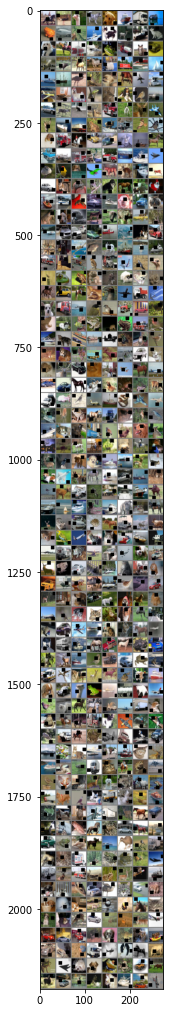

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

***Define the final target classes in CIFAR***


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

***Load Custom A11 model and print summary***
<hr>

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = mdl.resnet_modified_A11().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        Dropout2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
       BasicBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

***Running for 20 Epochs with lenearly increasing LR to find max_lr for OCP***
<hr>

In [9]:
EPOCHS = 20

# lrs = np.logspace(-4, 0, EPOCHS)
lrs = np.linspace(1e-4, 1, EPOCHS)
mtms = np.linspace(0.9, 0.9, EPOCHS)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
scheduler = ListScheduler(optimizer, lrs=lrs, momentums=mtms)


for epoch in range(EPOCHS):
    model = mdl.resnet_modified_A11().to(device)
    print("EPOCH:", epoch+1)
    current_lr = [g['lr'] for g in optimizer.param_groups]
    current_m = [g['momentum'] for g in optimizer.param_groups]
    print('LR: {}, M : {}'.format(current_lr, current_m))
    ta, tl, ta_epoch, tl_epoch   =  ttfunc.train(model, device, trainloader, optimizer, epoch)
    ta1, tl1 =  ttfunc.test(model, device, testloader, classes)
    scheduler.step()
    print('')


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: [0.0001], M : [0.0]


Loss=3.5144104957580566 Batch_id=97 Accuracy=9.77: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 942/10000 (9.42%)


EPOCH: 2
LR: [0.05272631578947369], M : [0.0]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 1044/10000 (10.44%)


EPOCH: 3
LR: [0.10535263157894736], M : [0.0]


Loss=3.2105038166046143 Batch_id=97 Accuracy=11.18: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 1099/10000 (10.99%)


EPOCH: 4
LR: [0.15797894736842105], M : [0.0]


Loss=3.1376218795776367 Batch_id=97 Accuracy=9.68: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 971/10000 (9.71%)


EPOCH: 5
LR: [0.21060526315789474], M : [0.0]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 1087/10000 (10.87%)


EPOCH: 6
LR: [0.2632315789473684], M : [0.0]


Loss=3.0823071002960205 Batch_id=97 Accuracy=10.69: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 1013/10000 (10.13%)


EPOCH: 7
LR: [0.3158578947368421], M : [0.0]


Loss=3.1415066719055176 Batch_id=97 Accuracy=10.35: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 968/10000 (9.68%)


EPOCH: 8
LR: [0.3684842105263158], M : [0.0]


Loss=2.9726879596710205 Batch_id=97 Accuracy=9.94: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 1015/10000 (10.15%)


EPOCH: 9
LR: [0.4211105263157895], M : [0.0]


Loss=2.6904513835906982 Batch_id=97 Accuracy=10.07: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 1072/10000 (10.72%)


EPOCH: 10
LR: [0.47373684210526323], M : [0.0]


Loss=3.261906147003174 Batch_id=97 Accuracy=11.00: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 1136/10000 (11.36%)


EPOCH: 11
LR: [0.5263631578947369], M : [0.0]


Loss=3.2336313724517822 Batch_id=97 Accuracy=9.99: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 1020/10000 (10.20%)


EPOCH: 12
LR: [0.5789894736842105], M : [0.0]


Loss=3.3679440021514893 Batch_id=97 Accuracy=9.67: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 1057/10000 (10.57%)


EPOCH: 13
LR: [0.6316157894736842], M : [0.0]


Loss=4.718355655670166 Batch_id=97 Accuracy=10.00: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 1002/10000 (10.02%)


EPOCH: 14
LR: [0.684242105263158], M : [0.0]


Loss=3.3238677978515625 Batch_id=97 Accuracy=10.09: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 1013/10000 (10.13%)


EPOCH: 15
LR: [0.7368684210526316], M : [0.0]


Loss=3.0540473461151123 Batch_id=97 Accuracy=10.22: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 1040/10000 (10.40%)


EPOCH: 16
LR: [0.7894947368421052], M : [0.0]


Loss=3.6802425384521484 Batch_id=97 Accuracy=9.34: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 876/10000 (8.76%)


EPOCH: 17
LR: [0.842121052631579], M : [0.0]


Loss=3.674281120300293 Batch_id=97 Accuracy=10.01: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 1033/10000 (10.33%)


EPOCH: 18
LR: [0.8947473684210527], M : [0.0]


Loss=3.514066457748413 Batch_id=97 Accuracy=10.02: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 995/10000 (9.95%)


EPOCH: 19
LR: [0.9473736842105263], M : [0.0]


Loss=3.3216776847839355 Batch_id=97 Accuracy=9.78: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 892/10000 (8.92%)


EPOCH: 20
LR: [1.0], M : [0.0]


Loss=2.6615328788757324 Batch_id=97 Accuracy=9.79: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]



Test set: Average loss: 0.0053, Accuracy: 994/10000 (9.94%)




***Setting min_lr as 1/10th of max_lr for One cycle policy***
<hr>

In [10]:
max_lr = lrs[ta_epoch.index(max(ta_epoch))]
min_lr = max_lr/10
print(max_lr)
print(min_lr)
# print(max(ta_epoch))
# print(ta_epoch.index(max(ta_epoch)))
# print(lrs[ta_epoch.index(max(ta_epoch))])
# print(lrs[ta_epoch.index(max(ta_epoch))]/10)
# ta_epoch



0.10535263157894738
0.010535263157894739


***Plotting accuracy vs LR curve and taking max_lr as value with max accuracy***
<hr>

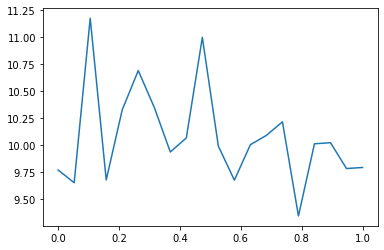

In [11]:
plt.plot(lrs,ta_epoch)

***Creating schedules of LR and momentum for final One cycle model training***
<hr>

In [12]:
lr_s = np.interp(np.arange(24), [0, 4, 23, 24], [min_lr, max_lr, min_lr, 0])
mtm_s = np.interp(np.arange(24), [0, 4, 23, 24], [0.95, 0.8, 0.95, 0.95])

print(lr_s)
print(mtm_s)

[0.01053526 0.03423961 0.05794395 0.08164829 0.10535263 0.10036224
 0.09537186 0.09038147 0.08539108 0.08040069 0.0754103  0.07041992
 0.06542953 0.06043914 0.05544875 0.05045837 0.04546798 0.04047759
 0.0354872  0.03049681 0.02550643 0.02051604 0.01552565 0.01053526]
[0.95       0.9125     0.875      0.8375     0.8        0.80789474
 0.81578947 0.82368421 0.83157895 0.83947368 0.84736842 0.85526316
 0.86315789 0.87105263 0.87894737 0.88684211 0.89473684 0.90263158
 0.91052632 0.91842105 0.92631579 0.93421053 0.94210526 0.95      ]


***Model Training***
---
<hr>

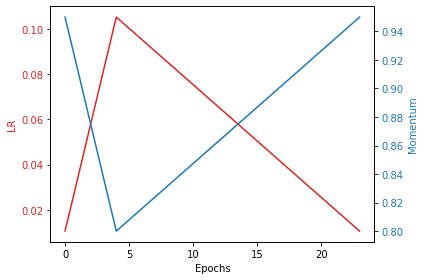

In [13]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LR', color=color)
ax1.plot(np.arange(24), lr_s, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Momentum', color=color)
ax2.plot(np.arange(24), mtm_s, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()


# plt.plot(np.arange(24),lr_s)
# plt.plot(np.arange(24),mtm_s)

In [14]:
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
train_acc = []
train_loss = []
val_acc = []
val_loss = []


# model1 =  mfile.resnet18().to(device)
model1 =  mdl.resnet_modified_A11().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.1, momentum = 0.9, weight_decay=0.001)
scheduler1 = ListScheduler(optimizer1, lrs=lr_s, momentums=mtm_s)
EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    current_lr = [g['lr'] for g in optimizer1.param_groups]
    current_m = [g['momentum'] for g in optimizer1.param_groups]
    print('LR: {}, M : {}'.format(current_lr, current_m))
    tr_ac_batch, tr_ls_batch, tr_ac_epoch, tr_ls_epoch   =  ttfunc.train(model1, device, trainloader, optimizer1, epoch)
    ts_ac, ts_ls =  ttfunc.test(model1, device, testloader, classes)
    scheduler1.step()
    print('')


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
LR: [0.010535263157894739], M : [0.9500000000000001]


Loss=1.9377508163452148 Batch_id=97 Accuracy=18.50: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 2324/10000 (23.24%)


EPOCH: 2
LR: [0.0342396052631579], M : [0.9125]


Loss=1.715477705001831 Batch_id=97 Accuracy=27.35: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 3839/10000 (38.39%)


EPOCH: 3
LR: [0.057943947368421046], M : [0.875]


Loss=1.6238694190979004 Batch_id=97 Accuracy=38.75: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4616/10000 (46.16%)


EPOCH: 4
LR: [0.08164828947368422], M : [0.8375]


Loss=1.415234923362732 Batch_id=97 Accuracy=48.59: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 5308/10000 (53.08%)


EPOCH: 5
LR: [0.10535263157894736], M : [0.8]


Loss=1.146681785583496 Batch_id=97 Accuracy=55.63: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 6052/10000 (60.52%)


EPOCH: 6
LR: [0.10036224376731302], M : [0.8078947368421053]


Loss=0.8873235583305359 Batch_id=97 Accuracy=63.70: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6814/10000 (68.14%)


EPOCH: 7
LR: [0.09537185595567868], M : [0.8157894736842105]


Loss=0.8518902063369751 Batch_id=97 Accuracy=70.44: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6950/10000 (69.50%)


EPOCH: 8
LR: [0.09038146814404432], M : [0.8236842105263158]


Loss=0.6123205423355103 Batch_id=97 Accuracy=74.57: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7744/10000 (77.44%)


EPOCH: 9
LR: [0.08539108033240998], M : [0.8315789473684211]


Loss=0.6316991448402405 Batch_id=97 Accuracy=78.13: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8053/10000 (80.53%)


EPOCH: 10
LR: [0.08040069252077564], M : [0.8394736842105264]


Loss=0.5461983680725098 Batch_id=97 Accuracy=80.90: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8199/10000 (81.99%)


EPOCH: 11
LR: [0.07541030470914128], M : [0.8473684210526315]


Loss=0.3914516866207123 Batch_id=97 Accuracy=82.75: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8384/10000 (83.84%)


EPOCH: 12
LR: [0.07041991689750693], M : [0.8552631578947368]


Loss=0.36487191915512085 Batch_id=97 Accuracy=83.99: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8348/10000 (83.48%)


EPOCH: 13
LR: [0.06542952908587259], M : [0.8631578947368421]


Loss=0.430919885635376 Batch_id=97 Accuracy=85.47: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8144/10000 (81.44%)


EPOCH: 14
LR: [0.060439141274238245], M : [0.8710526315789474]


Loss=0.4318462908267975 Batch_id=97 Accuracy=86.63: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8623/10000 (86.23%)


EPOCH: 15
LR: [0.05544875346260389], M : [0.8789473684210526]


Loss=0.42740339040756226 Batch_id=97 Accuracy=87.27: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8529/10000 (85.29%)


EPOCH: 16
LR: [0.05045836565096954], M : [0.8868421052631579]


Loss=0.4079808294773102 Batch_id=97 Accuracy=87.91: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8616/10000 (86.16%)


EPOCH: 17
LR: [0.04546797783933519], M : [0.8947368421052632]


Loss=0.2787247896194458 Batch_id=97 Accuracy=89.16: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8539/10000 (85.39%)


EPOCH: 18
LR: [0.040477590027700835], M : [0.9026315789473686]


Loss=0.3255760669708252 Batch_id=97 Accuracy=89.44: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8798/10000 (87.98%)


EPOCH: 19
LR: [0.035487202216066493], M : [0.9105263157894736]


Loss=0.2988359034061432 Batch_id=97 Accuracy=90.67: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8741/10000 (87.41%)


EPOCH: 20
LR: [0.03049681440443215], M : [0.9184210526315789]


Loss=0.33942684531211853 Batch_id=97 Accuracy=91.24: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8860/10000 (88.60%)


EPOCH: 21
LR: [0.025506426592797796], M : [0.9263157894736842]


Loss=0.2545587718486786 Batch_id=97 Accuracy=92.14: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8742/10000 (87.42%)


EPOCH: 22
LR: [0.02051603878116344], M : [0.9342105263157895]


Loss=0.24159292876720428 Batch_id=97 Accuracy=93.09: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8882/10000 (88.82%)


EPOCH: 23
LR: [0.015525650969529098], M : [0.9421052631578948]


Loss=0.2013140618801117 Batch_id=97 Accuracy=93.71: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8947/10000 (89.47%)


EPOCH: 24
LR: [0.010535263157894739], M : [0.9500000000000001]


Loss=0.12283075600862503 Batch_id=97 Accuracy=94.68: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]



Test set: Average loss: 0.0006, Accuracy: 9038/10000 (90.38%)




In [0]:
# model

***Checking test data performance/results***
<hr>

------------------------------------------------------------
Model accuracy on 10000 test images: 90.38%
------------------------------------------------------------
 
Category   - Accuracy
plane      - 94.30
car        - 95.60
bird       - 78.60
cat        - 78.60
deer       - 94.50
dog        - 88.20
frog       - 94.20
horse      - 93.30
ship       - 90.50
truck      - 96.00
 


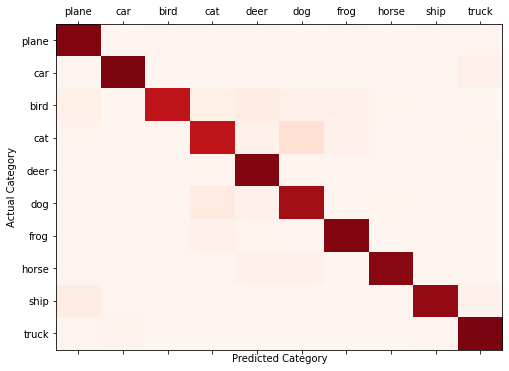

In [15]:
tperform.test_performance(model1, testloader, device, classes)

***Show misclassified TEST images***
<hr>

In [0]:
# mp.train_testplots(trainloss = tr_ls_batch , trainacc = tr_ac_batch, testloss = ts_ls , testacc = ts_ac)

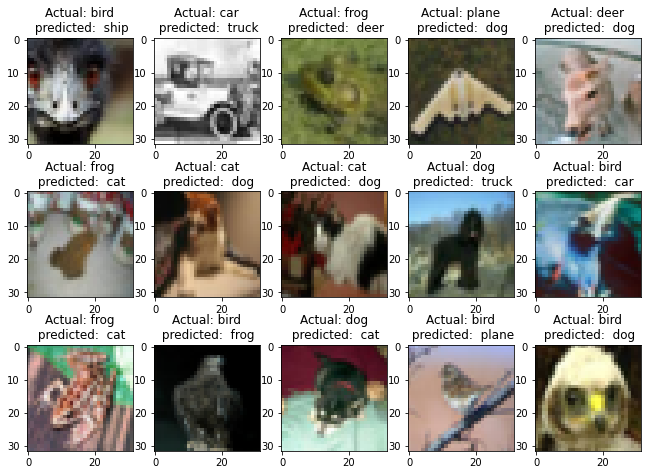

In [17]:
images, actuals, preds = misclassified.test_misclassified(model1,device,testloader)
misclassified.plot_images(images, actuals, preds, classes)